In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import pandas as pd
from branca.colormap import linear
from DadosAbertosBrasil import ibge
import statsmodels.api as sm
import warnings
from branca.colormap import LinearColormap
warnings.filterwarnings("ignore")
import mplleaflet


/Users/juliasbardelatti/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
df = pd.read_csv("analise_geral.csv")
df = df.query("ano == 2014 or ano == 2024")
df.head()

,Unnamed: 0,regiao,codigo_uf,uf,codigo_ibge,municipio,qtd_magreza_acentuada,perc_magreza_acentuada,qtd_magreza,perc_magreza,qtd_eutrofia,perc_eutrofia,qtd_sobrepeso,perc_sobrepeso,qtd_obesidade,perc_obesidade,qtd_obesidade_grave,perc_obesidade_grave,total,ano
0,0,CENTRO-OESTE,53.0,DF,530010.0,BRASILIA,237.0,0.0153,448.0,0.0288,11.296,0.7274,2.486,0.1601,900.0,0.0580,163.0,0.0105,15.530,2014
1,1,TOTAL ESTADO DISTRITO FEDERAL,NaN,NaN,NaN,NaN,237.0,0.0153,448.0,0.0288,11.296,0.7274,2.486,0.1601,900.0,0.0580,163.0,0.0105,15.530,2014
2,2,CENTRO-OESTE,52.0,GO,520005.0,ABADIA DE GOIAS,5.0,0.0198,8.0,0.0316,174,0.6877,49.0,0.1937,13.0,0.0514,4.0,0.0158,253,2014
3,3,CENTRO-OESTE,52.0,GO,520010.0,ABADIANIA,5.0,0.0173,8.0,0.0277,211,0.7301,48.0,0.1661,13.0,0.0450,4.0,0.0138,289,2014
4,4,CENTRO-OESTE,52.0,GO,520013.0,ACREUNA,7.0,0.0115,22.0,0.0362,420,0.6908,105.0,0.1727,43.0,0.0707,11.0,0.0181,608,2014


In [5]:
df_estado = df[df['regiao'].str.startswith(('TOTAL ESTADO'), na=False)]
df_estado['NOME'] = df_estado['regiao'].str.replace('TOTAL ESTADO ', '').str.strip()

In [6]:
base_codigos = pd.read_csv("estados.csv")
base_codigos['NOME'] = base_codigos['NOME'].str.upper()
resultado = df_estado.merge(base_codigos, on='NOME', how='left')

In [7]:
colunas_para_converter = ['perc_magreza_acentuada', 'perc_magreza', 'perc_eutrofia', 'perc_sobrepeso', 'perc_obesidade', 'perc_obesidade_grave'] 

for coluna in colunas_para_converter:
    resultado[coluna] = pd.to_numeric(resultado[coluna], errors='coerce') 

resultado['excesso_de_peso'] = (resultado['perc_sobrepeso'] + resultado['perc_obesidade'] + resultado['perc_obesidade_grave']) 

In [8]:
resultado = resultado[['ano', 'NOME', 'COD', 'SIGLA', 'excesso_de_peso']]

In [9]:
resultado['ano'] = resultado['ano'].astype(int)

df_2014 = resultado[resultado['ano'] == 2014].set_index(['COD', 'SIGLA', 'NOME'])
df_2024 = resultado[resultado['ano'] == 2024].set_index(['COD', 'SIGLA', 'NOME'])

df_comparado = df_2014[['excesso_de_peso']].join(
    df_2024[['excesso_de_peso']], lsuffix='_2014', rsuffix='_2024'
)

In [10]:
df_comparado['variacao_absoluta'] = (df_comparado['excesso_de_peso_2024'] - df_comparado['excesso_de_peso_2014'])
df_comparado = df_comparado.reset_index()

In [11]:
df_comparado.sort_values("variacao_absoluta", ascending=False).to_clipboard(decimal=",")

In [12]:
geojson_path = ibge.malha(
    nivel = 'paises',
    localidade = 'BR',
    divisoes = 'uf',
    formato = 'geojson'
)

In [13]:
mapa = folium.Map(location=[-14.2350, -51.9253], zoom_start=4, tiles=None)

if isinstance(geojson_path, dict):
    gdf = gpd.GeoDataFrame.from_features(geojson_path["features"])
else:
    gdf = gpd.read_file(geojson_path)

gdf["codarea"] = gdf["codarea"].astype(int)
siglas = {
    11: "RO", 12: "AC", 13: "AM", 14: "RR", 15: "PA", 16: "AP", 17: "TO",
    21: "MA", 22: "PI", 23: "CE", 24: "RN", 25: "PB", 26: "PE", 27: "AL", 28: "SE", 29: "BA",
    31: "MG", 32: "ES", 33: "RJ", 35: "SP",
    41: "PR", 42: "SC", 43: "RS",
    50: "MS", 51: "MT", 52: "GO", 53: "DF"
}
gdf["sigla"] = gdf["codarea"].map(siglas)
df_comparado["variacao_absoluta"] = df_comparado["variacao_absoluta"] * 100

min_val = df_comparado["variacao_absoluta"].min()
max_val = df_comparado["variacao_absoluta"].max()

colormap = LinearColormap(
    colors=["#ffffe5", "#fee391", "#fcae91", "#fb6a4a", "#de2d26", "#a50f15"],
    vmin=min_val,
    vmax=max_val,
    caption="Variação em pontos percentuais"
)
colormap.add_to(mapa) 

def style_function(feature):
    cod = int(feature["properties"]["codarea"])
    row = df_comparado[df_comparado["COD"] == cod]
    if not row.empty:
        variacao = row.iloc[0]["variacao_absoluta"]
        color = colormap(variacao)
    else:
        color = "white"  # Quando não há dados, mantém o preenchimento branco

    return {
        "fillColor": color,
        "color": "black",  # Aumenta o contraste da borda para "black"
        "weight": 0.8,  # Aumenta o peso da borda
        "fillOpacity": 0.7,
        "opacity": 0.8,  # Aumenta a opacidade para garantir visibilidade
    }

folium.GeoJson(
    geojson_path,
    style_function=style_function,
    name="Variação"
).add_to(mapa)

for _, row in gdf.iterrows():
    estado_codigo = row["codarea"]
    centroide = row.geometry.centroid
    variacao_absoluta = df_comparado.loc[df_comparado["COD"] == estado_codigo, "variacao_absoluta"]
    
    if not variacao_absoluta.empty:
        variacao_valor = round(variacao_absoluta.values[0], 0)
        sigla_estado = row["sigla"]
        sinal = "+" if variacao_valor > 0 else ""
        texto_variacao = f"{sinal}{int(variacao_valor)}pp"

        if sigla_estado == "RN":
            centroide_y = centroide.y + 0.4
            centroide_x = centroide.x
        elif sigla_estado == "AL":
            centroide_y = centroide.y
            centroide_x = centroide.x + 0.8  
        elif sigla_estado == "PB":
            centroide_y = centroide.y
            centroide_x = centroide.x + 0.8  
        else:
            centroide_y = centroide.y
            centroide_x = centroide.x

        destaque = abs(variacao_valor) >= 10
        print(destaque)
        cor_texto = "red" if destaque else "black"
        tamanho = "13px" if destaque else "13px"

        folium.Marker(
            location=[centroide_y, centroide_x],
            icon=folium.DivIcon(html=f"""
                <div style="font-size: {tamanho}; font-weight: bold; color: {cor_texto}; 
                            background-color: rgba(255, 255, 255, 0.9); 
                            padding: 2px 6px; border-radius: 6px; 
                            min-width: 50px; text-align: center;">
                    {sigla_estado}<br>{texto_variacao}
                </div>
            """)
        ).add_to(mapa)
titulo_html = """
<div style="
    position: fixed; 
    top: 10px; left: 50%; 
    transform: translateX(-50%);
    z-index: 9999; 
    background-color: white; 
    padding: 10px; 
    border-radius: 8px;
    font-size: 18px; 
    font-weight: bold;
    box-shadow: 0 0 5px rgba(0,0,0,0.2);
">
        Variação em pontos percentuais do excesso de peso em adolescentes no Brasil (2014–2024)

</div>
"""
mapa.get_root().html.add_child(folium.Element(titulo_html))
mapa.get_root().html.add_child(folium.Element("""
    <style>
        .legend {
            position: fixed !important;
            top: 50px !important;
            left: 50% !important;
            transform: translateX(-50%);
            z-index: 9998;
        }
    </style>
"""))
mapa.get_root().html.add_child(folium.Element("""
    <style>
        html, body {
            background-color: white !important;
            height: 100%;
            margin: 0;
        }
        .folium-map { background: white; }
        #map { height: 100%; }
    </style>
"""))

mapa.save("mapa_com_siglas.html")

True
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


#### Análise região urbana e rural

In [14]:
tipologia_municipal = pd.read_excel("../../tipologia_rural_ou_urbano.xlsx")
tipologia_municipal.query("NM_MUN == 'Brasília'")

,NM_UF,SIG_UF,CD_GCMUN,NM_MUN,TIPO
5564,Distrito Federal,DF,5300108,Brasília,Urbano


In [15]:
len(df_merge_completo)

NameError: name 'df_merge_completo' is not defined

In [ ]:
municipios_cod = pd.read_csv("../../municipios_regioes.csv")
municipios_cod.query("nome_municipio == 'Brasília'")

,Unnamed: 0,cod_uf,codigo_municipio_ibge,nome_municipio,codigo_municipio_ibge_novo,nome_uf,uf,regiao
5569,5569,53,5300108,Brasília,530010,Distrito Federal,DF,Centro-Oeste


In [ ]:
df_merge = pd.merge(municipios_cod, tipologia_municipal, left_on='codigo_municipio_ibge', right_on='CD_GCMUN')
df_merge = df_merge[['cod_uf', 'nome_uf', 'uf', 'codigo_municipio_ibge', 'nome_municipio', 'codigo_municipio_ibge_novo', 'TIPO']]

In [ ]:
df = df.query("codigo_ibge != 'Código IBGE' and ano == 2024")
df_municipios = df[df['municipio'].notnull()]

In [ ]:
df_municipios['codigo_ibge'] = df_municipios['codigo_ibge'].astype('int')
df_merge['codigo_municipio_ibge_novo'] = df_merge['codigo_municipio_ibge_novo'].astype('int')

In [ ]:
df_merge_completo = pd.merge(df_municipios, df_merge, left_on='codigo_ibge', right_on='codigo_municipio_ibge_novo')

In [ ]:
colunas_para_converter = ['perc_magreza_acentuada', 'perc_magreza', 'perc_eutrofia', 'perc_sobrepeso', 'perc_obesidade', 'perc_obesidade_grave'] 

for coluna in colunas_para_converter:
    df_merge_completo[coluna] = pd.to_numeric(df_merge_completo[coluna], errors='coerce') 
    #df_merge_completo[coluna] = df_merge_completo[coluna] / 100 

df_merge_completo['excesso_de_peso'] = (df_merge_completo['perc_sobrepeso'] + df_merge_completo['perc_obesidade'] + df_merge_completo['perc_obesidade_grave']) 

In [ ]:
df_merge_completo = df_merge_completo[['regiao', 'codigo_uf', 'nome_uf','municipio', 'TIPO', 'excesso_de_peso']]
df_merge_completo.query("municipio == 'BRUSQUE'")

,regiao,codigo_uf,nome_uf,municipio,TIPO,excesso_de_peso
5320,SUL,42.0,Santa Catarina,BRUSQUE,Urbano,0.3479


In [ ]:
len(df_merge_completo.query("TIPO == 'IntermediarioAdjacente'"))

686

In [ ]:
media_obesidade = df_merge_completo.groupby('TIPO').agg(
    media_excesso_peso=('excesso_de_peso', 'mean'),
    quantidade_municipios=('municipio', 'nunique')  
).reset_index()

media_obesidade.to_clipboard(decimal=",")


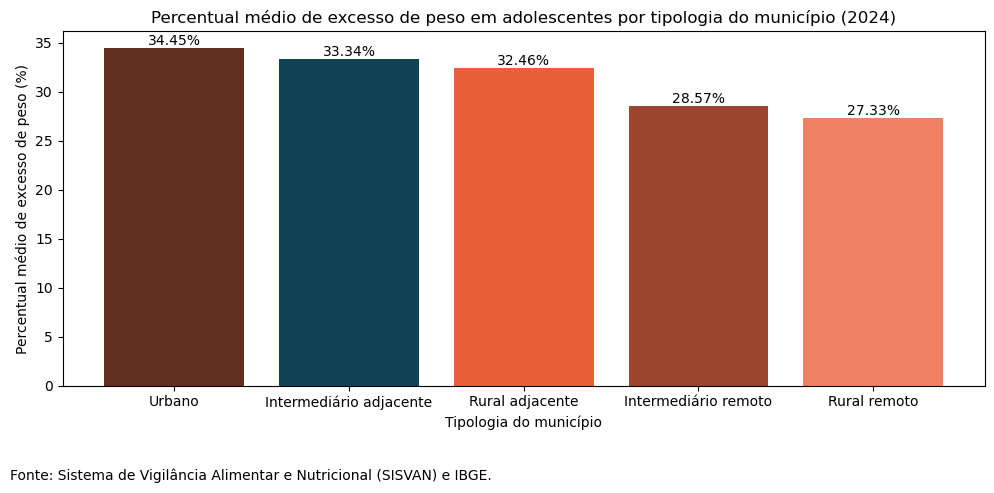

In [ ]:
nomes_formatados = {
    'Urbano': 'Urbano',
    'RuralAdjacente': 'Rural adjacente',
    'IntermediarioAdjacente': 'Intermediário adjacente',
    'IntermediarioRemoto': 'Intermediário remoto',
    'RuralRemoto': 'Rural remoto'
}

media_obesidade = df_merge_completo.groupby('TIPO')['excesso_de_peso'].mean().reset_index()
media_obesidade['TIPO_FORMATADA'] = media_obesidade['TIPO'].map(nomes_formatados)
media_obesidade = media_obesidade.sort_values(by='excesso_de_peso', ascending=False)
cat_colors = ["#114354", "#1F7A99", "#2EA6BC", "#81CBD3", "#632F21", "#9C462F", "#E95F3A", "#EF8264"]
plt.figure(figsize=(10, 5))
bars = plt.bar(
    media_obesidade['TIPO_FORMATADA'], 
    media_obesidade['excesso_de_peso'], 
    color=['#632F21', '#114354', '#E95F3A', "#9C462F", "#EF8264"]
)

plt.title('Percentual médio de excesso de peso em adolescentes por tipologia do município (2024)')
plt.ylabel('Percentual médio de excesso de peso (%)')
plt.xlabel('Tipologia do município')
plt.bar_label(bars, fmt='%.2f%%')
plt.xticks()
plt.figtext(0.01, -0.02, "Fonte: Sistema de Vigilância Alimentar e Nutricional (SISVAN) e IBGE.", ha="left", fontsize=10)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


In [ ]:
df_base_final = df_merge_completo[['municipio', 'TIPO', 'excesso_de_peso']]
df_base_final.head()

,municipio,TIPO,excesso_de_peso
0,BRASILIA,Urbano,27.86
1,ABADIA DE GOIAS,Urbano,32.87
2,ABADIANIA,RuralAdjacente,32.94
3,ACREUNA,Urbano,37.86
4,ADELANDIA,RuralAdjacente,40.01


In [ ]:
df_base_final = df_base_final.dropna(subset=['excesso_de_peso', 'TIPO'])

In [ ]:
dummies = pd.get_dummies(df_base_final['TIPO'], drop_first=True)
dummies = dummies.astype(float)

X = pd.concat([dummies], axis=1)
y = df_base_final['excesso_de_peso'].astype(float)
X = sm.add_constant(X)
modelo = sm.OLS(y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:        excesso_de_peso   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     94.08
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           1.61e-77
Time:                        17:04:11   Log-Likelihood:                -17960.
No. Observations:                5505   AIC:                         3.593e+04
Df Residuals:                    5500   BIC:                         3.596e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  33.3356    